# Homophily

Homophily is the network principle that describes the way that nodes which have common properties or attributes are likely to be or become linked to one another. It's sometimes also referred to as assortative mixing.

In order to see if a network is homophilous, there must be node attributes for you to investigate. The example below uses the node attributes in the Quaker network from the *Six Degrees of Francis Bacon* project.

## Importing data

In [1]:
# Import NetworkX and key data science libraries
import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme()

In [2]:
# Import edge table as normal
edges = pd.read_csv("data/quaker-edges.csv")
edges

,Source,Target
0,George Keith,William Bradford
1,George Keith,George Whitehead
2,George Keith,George Fox
3,George Keith,William Penn
4,George Keith,Franciscus Mercurius van Helmont
...,...,...
157,Joseph Besse,Samuel Bownas
158,Joseph Besse,Richard Claridge
159,Silvanus Bevan,Daniel Quare
160,John Penington,Mary Penington


In [3]:
# Import node table
nodes = pd.read_csv("data/quaker-nodes.csv")
nodes

,Id,Label,historical significance,gender,birthdate,deathdate,other_id
0,George Keith,George Keith,Quaker schismatic and Church of England clergyman,male,1638,1716,10006784
1,Robert Barclay,Robert Barclay,religious writer and colonial governor,male,1648,1690,10054848
2,Benjamin Furly,Benjamin Furly,merchant and religious writer,male,1636,1714,10004625
3,Anne Conway Viscountess Conway and Killultagh,Anne Conway Viscountess Conway and Killultagh,philosopher,female,1631,1679,10002755
4,Franciscus Mercurius van Helmont,Franciscus Mercurius van Helmont,physician and cabbalist,male,1614,1698,10005781
...,...,...,...,...,...,...,...
91,Elizabeth Leavens,Elizabeth Leavens,Quaker missionary,female,1555,1665,10007246
92,Lewis Morris,Lewis Morris,politician in America,male,1671,1746,10008534
93,Sir Charles Wager,Sir Charles Wager,naval officer and politician,male,1666,1743,10012403
94,William Simpson,William Simpson,Quaker preacher,male,1627,1671,10011114


In [4]:
# Add edges to graph object
quakers = nx.from_pandas_edgelist(edges, source="Source", target="Target")
print(quakers)

Graph with 96 nodes and 162 edges


In [5]:
# Add node attributes for gender
nx.set_node_attributes(quakers, dict(zip(nodes.Id, nodes.gender)), 'gender')

## Calculating mixed edge probability

In a network that is *not* homophilous, the expected probability of mixed edges is 2 times the product of the percentage of nodes in the first group (`p`) and the percentage of the nodes in the second group (`q`): $2pq$.

In [6]:
# Calculate percentage of male people in the Quaker graph, using pandas
p = nodes.gender.value_counts()["male"]/nodes.gender.count()
p

0.84375

In [7]:
# Calculate percentage of female people in the Quaker graph, using pandas
q = nodes.gender.value_counts()["female"]/nodes.gender.count()
q

0.15625

In [8]:
# Calculate probability of mixed edges
2*p*q

0.263671875

## Comparing to the observed number of mixed edges

We know that if the network is not homophilous we would expect that around 26% of its edges would be mixed edges. To test this we can first calculate the actual number of mixed edges and compare it to the probability above.

In [9]:
# Find the total number of mixed edges in the network
mixed_edges = len([(s,t) for s,t in quakers.edges if quakers.nodes[s]['gender'] != quakers.nodes[t]['gender']])
mixed_edges

32

In [10]:
# Get the percentage of mixed edges in the network
mixed_edges/quakers.number_of_edges()

0.19753086419753085

Let's define a "homophily" measure as the different between the expected percentage of mixed edges and the observed percentage of mixed edges.

In [11]:
def homophily(mixed_edges):
    return 2*p*q - mixed_edges/quakers.number_of_edges()

In [12]:
obs_homophily = homophily(mixed_edges)
obs_homophily

0.06614101080246915

Our observed homophily measure is .07: we know that the percentage of mixed edges in this graph is 7% less than the percentage we would expect to see in a graph that is *not* homophilous. But how do we know if this measure is significant?

## Hypothesis testing

To see whether our graph is *significantly* homophilous, we can set up a resampling procedure to create a hypothesis test for the homophily statistic. This is similar to how you would set up a permutation test for a difference in means.

In [13]:
# Create a simulation function
def simulate_mixed_edges(data, attribute, id_attr, graph):
    attr_column = data[attribute].sample(frac=1).reset_index(drop=True) # Reshuffle column
    nx.set_node_attributes(graph, dict(zip(data[id_attr], attr_column)), attribute) # Set node attribute
    mixed_edges = len([(s,t) for s,t in graph.edges if graph.nodes[s][attribute] != graph.nodes[t][attribute]]) # Get number of mixed edges
    return mixed_edges

In [14]:
# Simulate homophily 5000 times
sim_homophily = pd.Series([homophily(simulate_mixed_edges(nodes, 'gender', 'Id', quakers)) for i in range(5000)])
sim_homophily

0      -0.063489
1      -0.001760
2      -0.001760
3      -0.057316
4      -0.174600
          ...   
4995    0.047622
4996   -0.094353
4997    0.004413
4998    0.010585
4999    0.016758
Length: 5000, dtype: float64

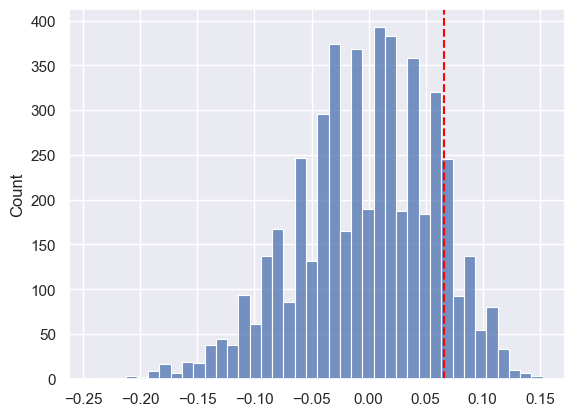

In [15]:
# Plot the results of the permutation test
plt = sns.histplot(x=sim_homophily)
plt.axvline(x=obs_homophily, color="red", ls="--")

In [16]:
# Calculate a p-value
p_value = np.mean(sim_homophily > obs_homophily)
p_value

0.1082

Now we can use the resulting graph and p-value to determine whether the amount of homophily we see in the Quaker graph is statistically significant.